In [5]:
import torch
import torch.utils.data as data
from torchvision import datasets, transforms
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from classes import CNN

In [ ]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [6]:
trainset = datasets.SVHN("data/train", split="train", download = False)
extraset = datasets.SVHN("data/extra", split="extra", download = False)

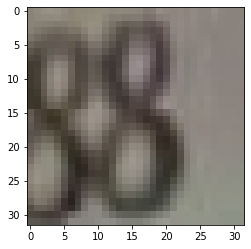

In [7]:
img = extraset.__getitem__(12)[0]
img_np = np.array(img)
plt.imshow(img_np)
plt.show()

In [ ]:
model = CNN()
model.load_state_dict(torch.load("model/mnist/model1.pth."))
print(model)